# Thematic differences GB

DHH23 Parliament group

Author: Pontus H.

Conservatives + Liberal Democrats: 11.05.2010 – 08.05.2015 (Cameron–Clegg coalition)

Conservatives: 08.05.2015 – 13.07.2016 (Second Cameron ministry)

Conservatives: 13.07.2016 – 11.07.2017 (First May Ministry)

Conservatives: 11.07.2017 – 24.07.2019 (Second May Ministry)

Conservatives: 24.07.2019 – 16.12.2019 (First Johnson Ministry)

Conservatives: 16.12.2019 – 06.09.2022 (Second Johnson Ministry)

In [172]:
# Set the theme here
THEME = 'healthcare_GB'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [173]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd
import numpy as np
import os

Set up the BERTopic pipeline

In [175]:
df = pd.read_csv(f'../data/{THEME}.csv')

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-GB_2017-11-20-commons.u80,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Wallace, Robert Ben Lobban",M,-,I am grateful to my hon. Friend for giving me ...,Friend for giving me the opportunity to point...,-0.443359,658
1,ParlaMint-GB_2017-11-20-commons.u137,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,LAB,Labour,Opposition,"Lee, Karen Elizabeth",F,-,"From December, the Policing and Crime Act 2017...","In Lincolnshire, with around 750,000 resident...",-0.813965,543
2,ParlaMint-GB_2017-11-20-commons.u153,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Whately, Helen Olivia Bicknell",F,-,Women who have suffered a sexual assault are a...,Will my hon,0.339355,213
3,ParlaMint-GB_2017-11-20-commons.u154,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Atkins, Victoria",F,-,My hon. Friend has led a strong campaign for e...,Friend has led a strong campaign for ensuring...,0.591309,583
4,ParlaMint-GB_2017-11-20-commons.u244,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,LAB,Labour,Opposition,"Hardy, Emma Ann",F,-,"Last Thursday, senior NHS leaders told me abou...",NaN,-0.216431,372


In [174]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [176]:
# Reference running time for this cell: 37s
topics, probs = topic_model.fit_transform(df['speech'])


In [177]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)

Number of topics before: 116


In [178]:
pd.Series(new_topics).value_counts()

 0      2291
 1      1480
 2      1451
 4      1401
 8      1324
        ... 
 114      93
 104      91
 112      78
 113      73
-1        56
Length: 116, dtype: int64

In [179]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [180]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [181]:
print(f"Number of topics after: {len(pd.Series(new_topics).unique())}")

Number of topics after: 116


In [182]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1      21738
 98      1330
 100      722
 111      688
 74       681
        ...  
 28        51
 3         51
 58        51
 26        50
 90        50
Length: 116, dtype: int64

In [183]:
topic_model.visualize_topics()

Topics over time

In [184]:
# Reference running time for this cell: 2min 30s
#topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [185]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [186]:
#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [187]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")

topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

Save relevant speeches from a particular subtopic

In [188]:
# Get the most relevant speeches from a topic and save to a text file

def save_topic_speeches(topic_id):
    speeches = topic_model.get_representative_docs(topic_id)
    with open(f"{OUTPUT_PATH}{THEME}/{THEME}_topic{topic_id}_speeches.txt", "w", encoding="utf-8") as file:
        file.write(f"Relevant speeches for theme {THEME} and topic {topic_id}\n\n")
        for speech in speeches:
            file.write(speech)
            file.write("\n\n")
# for topic_id in range(10):
#    save_topic_speeches(topic_id)

# Word Clouds

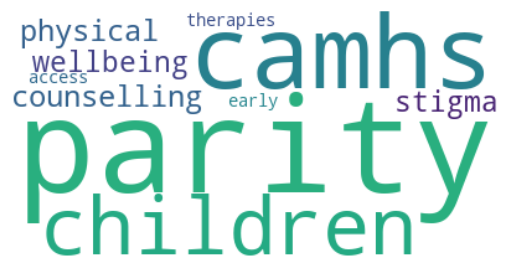

In [189]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [190]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [191]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [192]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
speech_topic_party.loc[speech_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
speech_topic_party.loc[speech_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
speech_topic_party.loc[speech_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}/{THEME}_speeches_topic_party.csv")
speech_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,1368,647,205,71
1,840,511,66,63
2,954,346,65,86
3,630,360,58,10
4,757,400,100,144
5,507,144,29,52
6,430,475,79,92
7,438,258,42,40
8,958,280,46,40


In [193]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,CON,LAB,OTHER,SNP
topic,,,,
0,18.2,17.2,27.7,11.2
1,11.2,13.6,8.9,9.9
2,12.7,9.2,8.8,13.5
3,8.4,9.5,7.8,1.6
4,10.1,10.6,13.5,22.7
5,6.8,3.8,3.9,8.2
6,5.7,12.6,10.7,14.5
7,5.8,6.8,5.7,6.3
8,12.8,7.4,6.2,6.3


In [194]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
#percentages.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_percentages.csv')
percentages

party,CON,LAB,OTHER,SNP,keywords
topic,,,,,
0,18.2,17.2,27.7,11.2,"[parity, camhs, children, counselling, physica..."
1,11.2,13.6,8.9,9.9,"[levy, integration, caring, precept, elderly, ..."
2,12.7,9.2,8.8,13.5,"[lockdown, coronavirus, variants, isolate, mea..."
3,8.4,9.5,7.8,1.6,"[pupil, colleges, disadvantaged, headteachers,..."
4,10.1,10.6,13.5,22.7,"[furlough, businesses, coronavirus, retention,..."
5,6.8,3.8,3.9,8.2,"[sports, drinks, childhood, advertising, overw..."
6,5.7,12.6,10.7,14.5,"[trade, brexit, customs, agreements, citizens,..."
7,5.8,6.8,5.7,6.3,"[speech, predecessor, east, deputy, queen, tri..."
8,12.8,7.4,6.2,6.3,"[questions, speaker, raise, ministers, adjourn..."


In [195]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
#percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,CON,LAB,OTHER,SNP
0,0,59.7,28.2,8.9,3.1
1,1,56.8,34.5,4.5,4.3
2,2,65.7,23.8,4.5,5.9
3,3,59.5,34.0,5.5,0.9
4,4,54.0,28.6,7.1,10.3
5,5,69.3,19.7,4.0,7.1
6,6,40.0,44.1,7.3,8.6
7,7,56.3,33.2,5.4,5.1
8,8,72.4,21.1,3.5,3.0
9,9,58.4,33.2,4.8,3.5


Calculate mean sentiment for each topic per party

In [196]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Create a new dataframe with the relevant speeches and remove duplicates
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
#sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_sentiment.csv')
sentiment_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,0.27,-0.33,-0.20,-0.22
1,0.18,-0.46,-0.25,-0.32
2,-0.00,-0.41,-0.44,-0.32
3,0.23,-0.29,-0.28,-0.13
4,0.27,-0.35,-0.12,-0.24
5,0.21,-0.17,-0.27,-0.08
6,0.10,-0.30,-0.40,-0.46
7,0.45,0.47,0.44,0.44
8,0.23,-0.30,-0.18,-0.43


In [197]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [198]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['CON', 'LAB', 'SNP', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'CON')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
16959,0,ParlaMint-GB_2015-06-02-commons.u136,CON,1.000000,2015-06-02,0.030921,May I start by saying that it was an incredibl...
43657,0,ParlaMint-GB_2019-02-25-commons.u446,CON,1.000000,2019-02-25,0.040769,My hon. Friend gives me a great opportunity to...
7781,0,ParlaMint-GB_2021-12-07-commons.u19,CON,1.000000,2021-12-07,0.004319,If Londoners are worrying about the state of t...
32771,0,ParlaMint-GB_2016-07-07-commons.u294,CON,-0.958008,2016-07-07,0.042307,"Exactly, as I was about to say. Let me continu..."
4303,0,ParlaMint-GB_2017-11-03-commons.u239,CON,-0.975098,2017-11-03,0.002915,I am delighted that we are having a robust deb...
...,...,...,...,...,...,...,...
43779,9,ParlaMint-GB_2019-03-05-commons.u498,OTHER,0.852539,2019-03-05,0.081520,"On the issue of health transformation, the per..."
11385,9,ParlaMint-GB_2021-07-21-commons.u195,OTHER,0.822754,2021-07-21,0.080641,I start by echoing the remarks of the Minister...
19086,9,ParlaMint-GB_2015-02-05-commons.u277,OTHER,-0.935547,2015-02-05,0.027879,"I accept that, of course. When I talk about pr..."
29922,9,ParlaMint-GB_2016-10-24-commons.u494,OTHER,-0.965820,2016-10-24,0.012782,That is a good question. When I have asked the...


In [199]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.CON', 'pf.LAB', 'pf.OTHER', 'pf.SNP', 'keywords', 'tc.CON', 'tc.LAB', 'tc.OTHER', 'tc.SNP', 's.CON', 's.LAB', 's.OTHER', 's.SNP']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.CON', 'tc.LAB', 'tc.SNP', 'tc.OTHER', 'pf.CON', 'pf.LAB', 'pf.SNP', 'pf.OTHER', 's.CON', 's.LAB', 's.SNP', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.CON,tc.LAB,tc.SNP,tc.OTHER,pf.CON,pf.LAB,pf.SNP,pf.OTHER,s.CON,s.LAB,s.SNP,s.OTHER
topic,,,,,,,,,,,,,
0,"[parity, camhs, children, counselling, physica...",59.7,28.2,3.1,8.9,18.2,17.2,11.2,27.7,0.27,-0.33,-0.22,-0.20
1,"[levy, integration, caring, precept, elderly, ...",56.8,34.5,4.3,4.5,11.2,13.6,9.9,8.9,0.18,-0.46,-0.32,-0.25
2,"[lockdown, coronavirus, variants, isolate, mea...",65.7,23.8,5.9,4.5,12.7,9.2,13.5,8.8,-0.00,-0.41,-0.32,-0.44
3,"[pupil, colleges, disadvantaged, headteachers,...",59.5,34.0,0.9,5.5,8.4,9.5,1.6,7.8,0.23,-0.29,-0.13,-0.28
4,"[furlough, businesses, coronavirus, retention,...",54.0,28.6,10.3,7.1,10.1,10.6,22.7,13.5,0.27,-0.35,-0.24,-0.12
5,"[sports, drinks, childhood, advertising, overw...",69.3,19.7,7.1,4.0,6.8,3.8,8.2,3.9,0.21,-0.17,-0.08,-0.27
6,"[trade, brexit, customs, agreements, citizens,...",40.0,44.1,8.6,7.3,5.7,12.6,14.5,10.7,0.10,-0.30,-0.46,-0.40
7,"[speech, predecessor, east, deputy, queen, tri...",56.3,33.2,5.1,5.4,5.8,6.8,6.3,5.7,0.45,0.47,0.44,0.44
8,"[questions, speaker, raise, ministers, adjourn...",72.4,21.1,3.0,3.5,12.8,7.4,6.3,6.2,0.23,-0.30,-0.43,-0.18
